# EXAMPLES ANIMATIONS

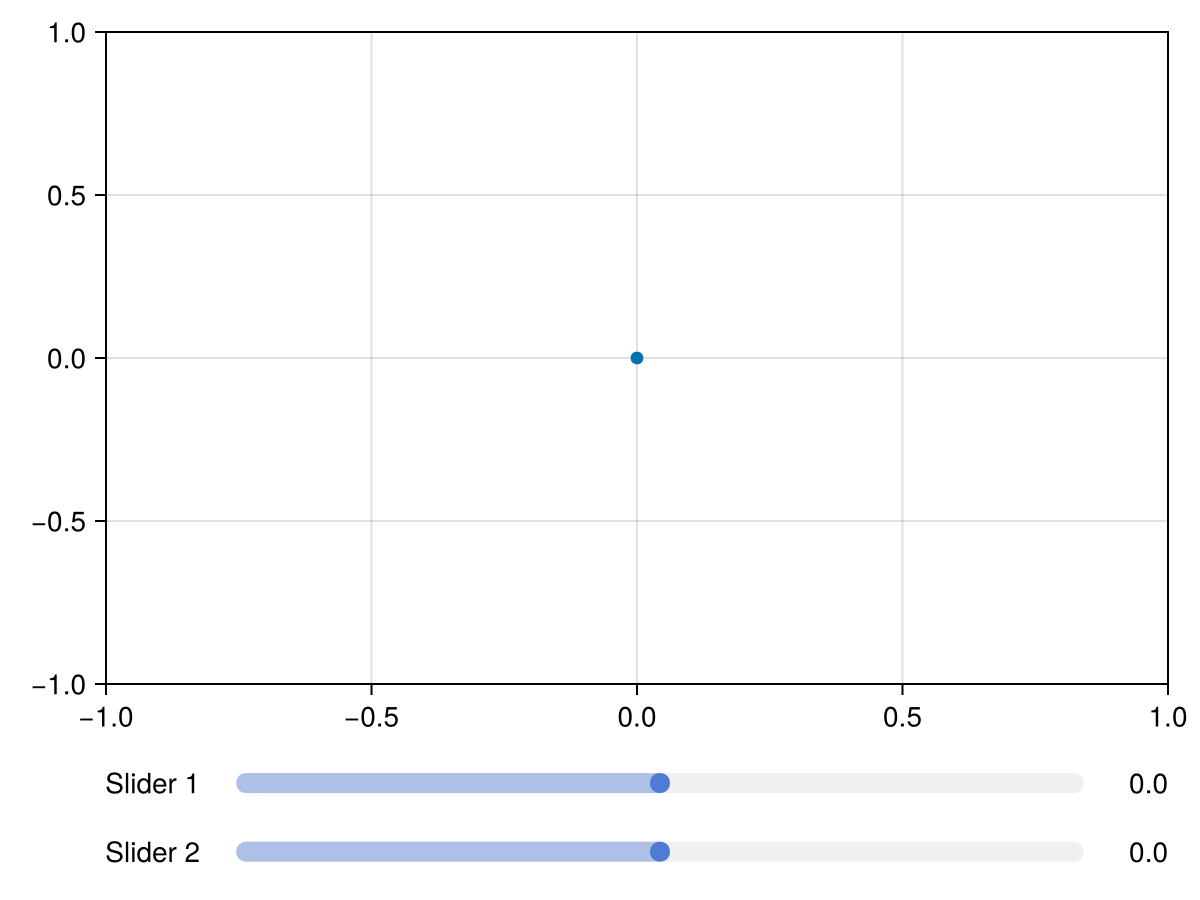

CairoMakie.Screen{IMAGE}


In [11]:
using GLMakie

figure = Figure()

# create two sliders
slider1, slider2 =
    Makie.SliderGrid(
        figure[2, 1],
        (; label = "Slider 1", range = -1:0.01:1),
        (; label = "Slider 2", range = -1:0.01:1),
    ).sliders

	 
obs_func = on(slider1.value) do val
	abs(val+slider2.value[])>0.01 && Makie.set_close_to!(slider2, -val)
end

obs_func2 = on(slider2.value) do val
	abs(slider1.value[]+val)>0.01 && Makie.set_close_to!(slider1, -val)
end

# create a slimple scatter point based on the slider (just a dummy for the purpose of this example)
data = @lift [Makie.Point2f($(slider1.value), $(slider2.value))]
scatter(figure[1, 1], data)

display(figure)

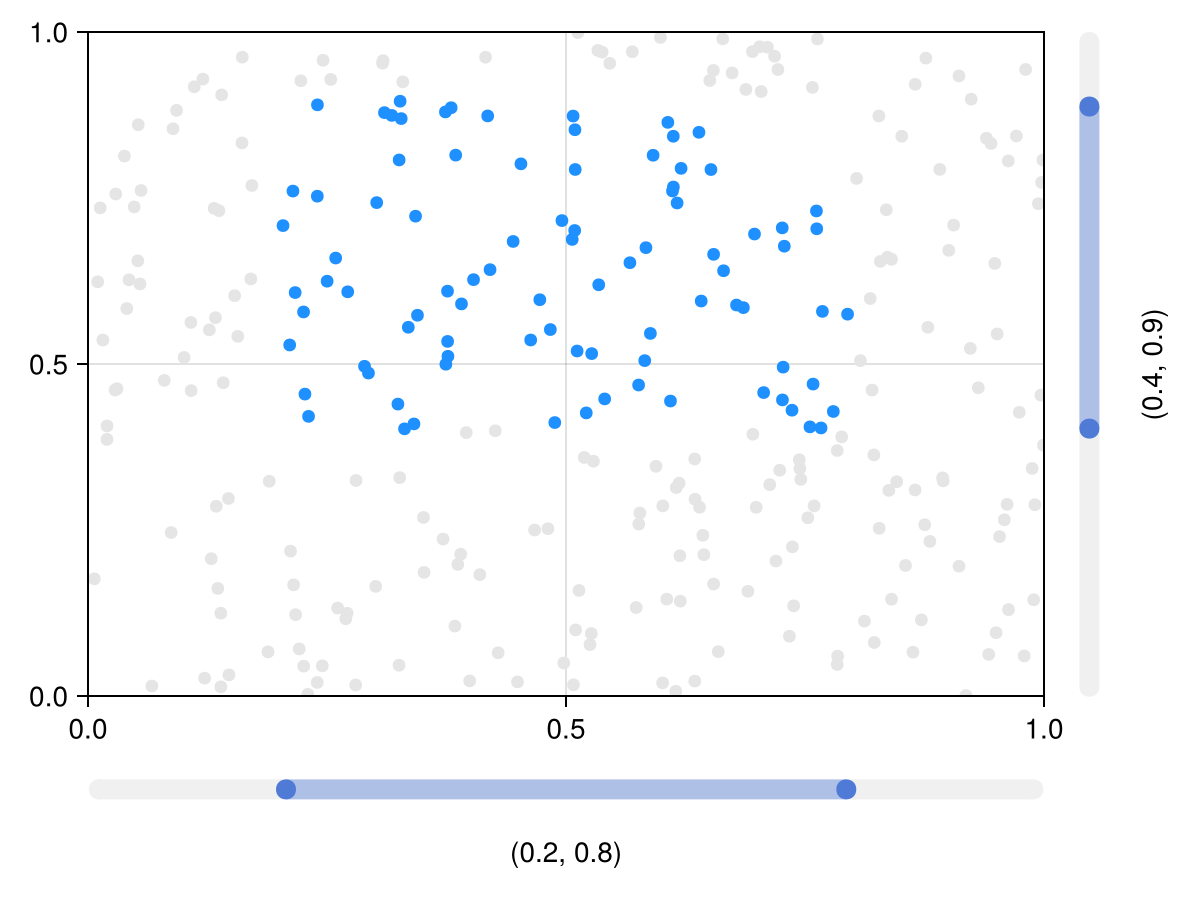

In [12]:
using GLMakie

f = Figure()
Axis(f[1, 1], limits = (0, 1, 0, 1))

rs_h = IntervalSlider(f[2, 1], range = LinRange(0, 1, 1000),
    startvalues = (0.2, 0.8))

rs_v = IntervalSlider(f[1, 2], range = LinRange(0, 1, 1000),
    startvalues = (0.4, 0.9), horizontal = false)

labeltext1 = lift(rs_h.interval) do int
    string(round.(int, digits = 2))
end

Label(f[3, 1], labeltext1, tellwidth = false)
labeltext2 = lift(rs_v.interval) do int
    string(round.(int, digits = 2))
end
Label(f[1, 3], labeltext2,
    tellheight = false, rotation = pi/2)

points = rand(Point2f, 300)

# color points differently if they are within the two intervals
colors = lift(rs_h.interval, rs_v.interval) do h_int, v_int
    map(points) do p
        (h_int[1] < p[1] < h_int[2]) && (v_int[1] < p[2] < v_int[2])
    end
end

scatter!(points, color = colors, colormap = [:gray90, :dodgerblue], strokewidth = 0)

f

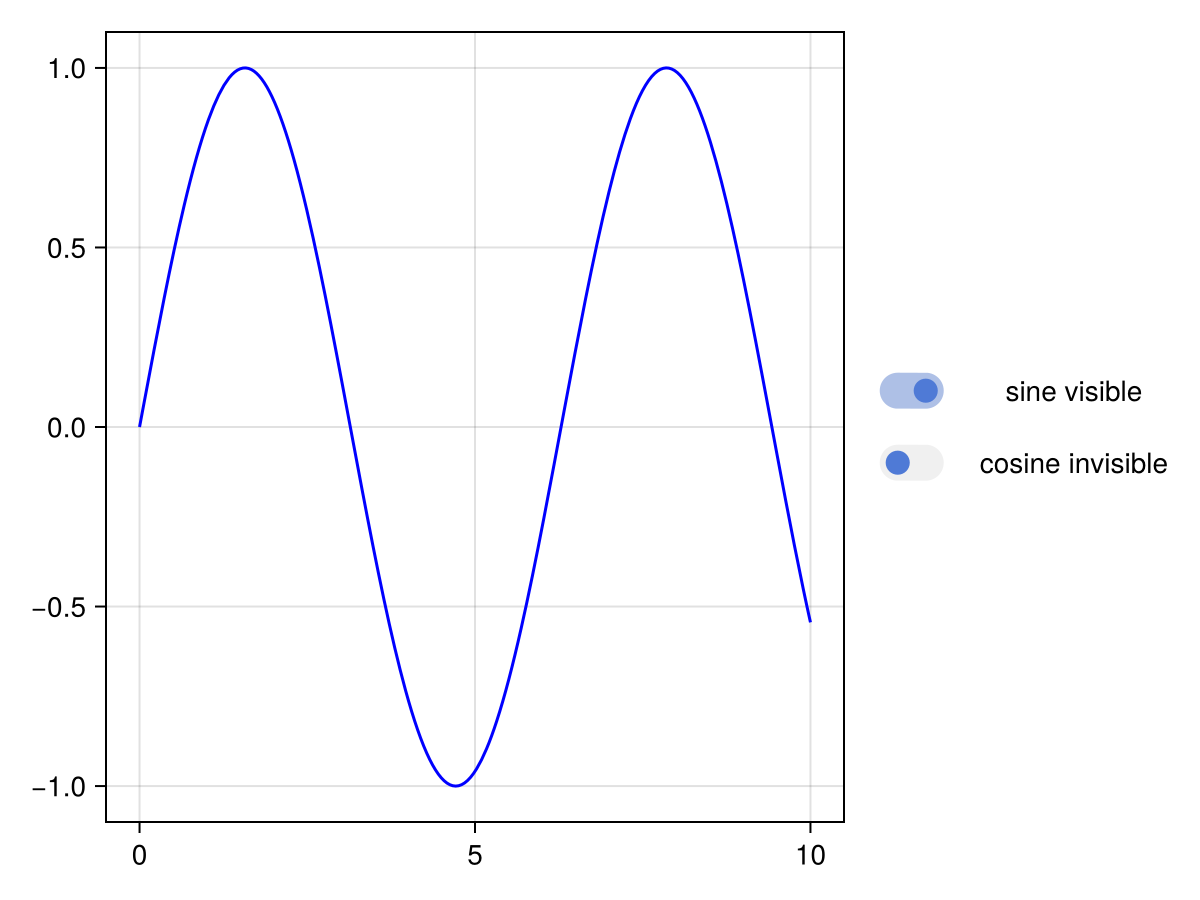

In [13]:
using GLMakie
fig = Figure()

ax = Axis(fig[1, 1])

toggles = [Toggle(fig, active = active) for active in [true, false]]
labels = [Label(fig, lift(x -> x ? "$l visible" : "$l invisible", t.active))
    for (t, l) in zip(toggles, ["sine", "cosine"])]

fig[1, 2] = grid!(hcat(toggles, labels), tellheight = false)

line1 = lines!(0..10, sin, color = :blue, visible = false)
line2 = lines!(0..10, cos, color = :red)

connect!(line1.visible, toggles[1].active)
connect!(line2.visible, toggles[2].active)

fig

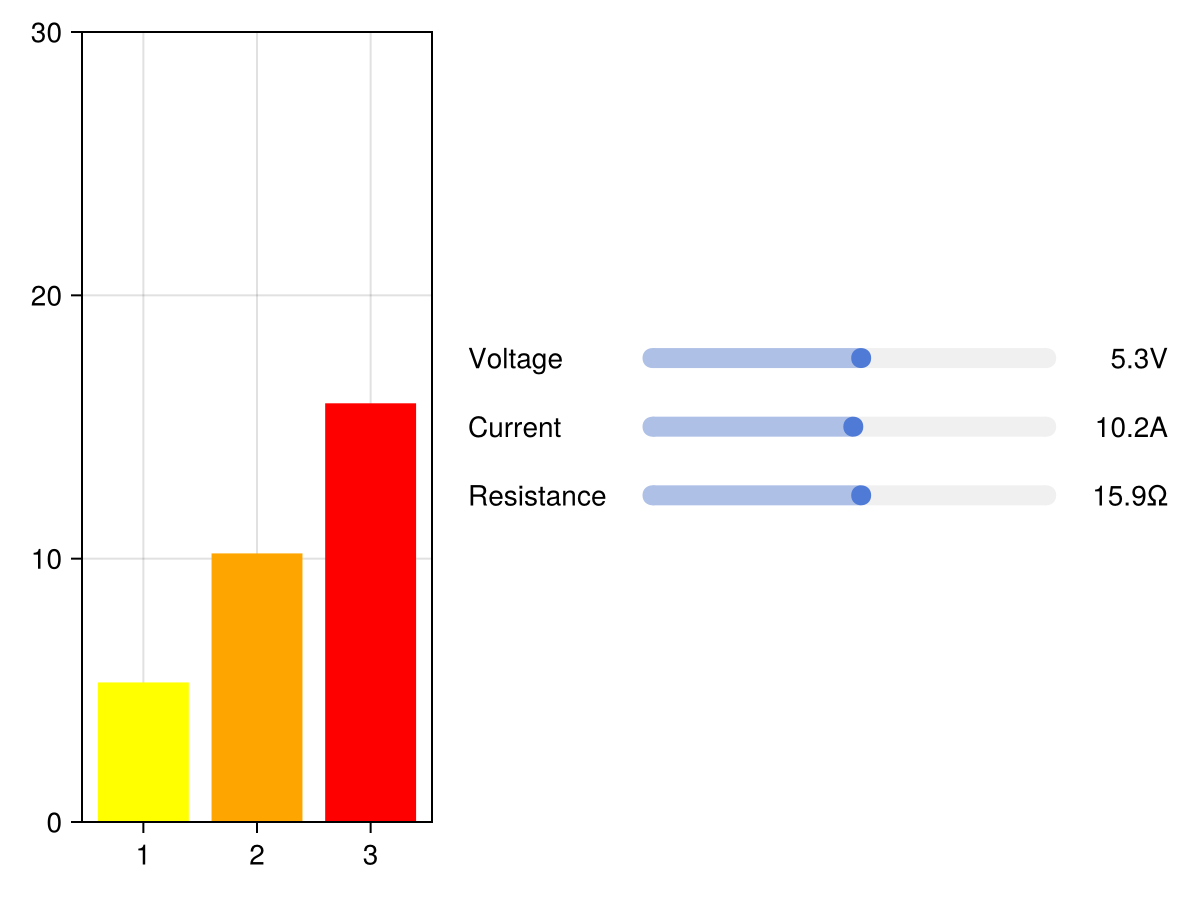

In [14]:
using GLMakie

fig = Figure()

ax = Axis(fig[1, 1])

sg = SliderGrid(
    fig[1, 2],
    (label = "Voltage", range = 0:0.1:10, format = "{:.1f}V", startvalue = 5.3),
    (label = "Current", range = 0:0.1:20, format = "{:.1f}A", startvalue = 10.2),
    (label = "Resistance", range = 0:0.1:30, format = "{:.1f}Ω", startvalue = 15.9),
    width = 350,
    tellheight = false)

sliderobservables = [s.value for s in sg.sliders]
bars = lift(sliderobservables...) do slvalues...
    [slvalues...]
end

barplot!(ax, bars, color = [:yellow, :orange, :red])
ylims!(ax, 0, 30)

fig

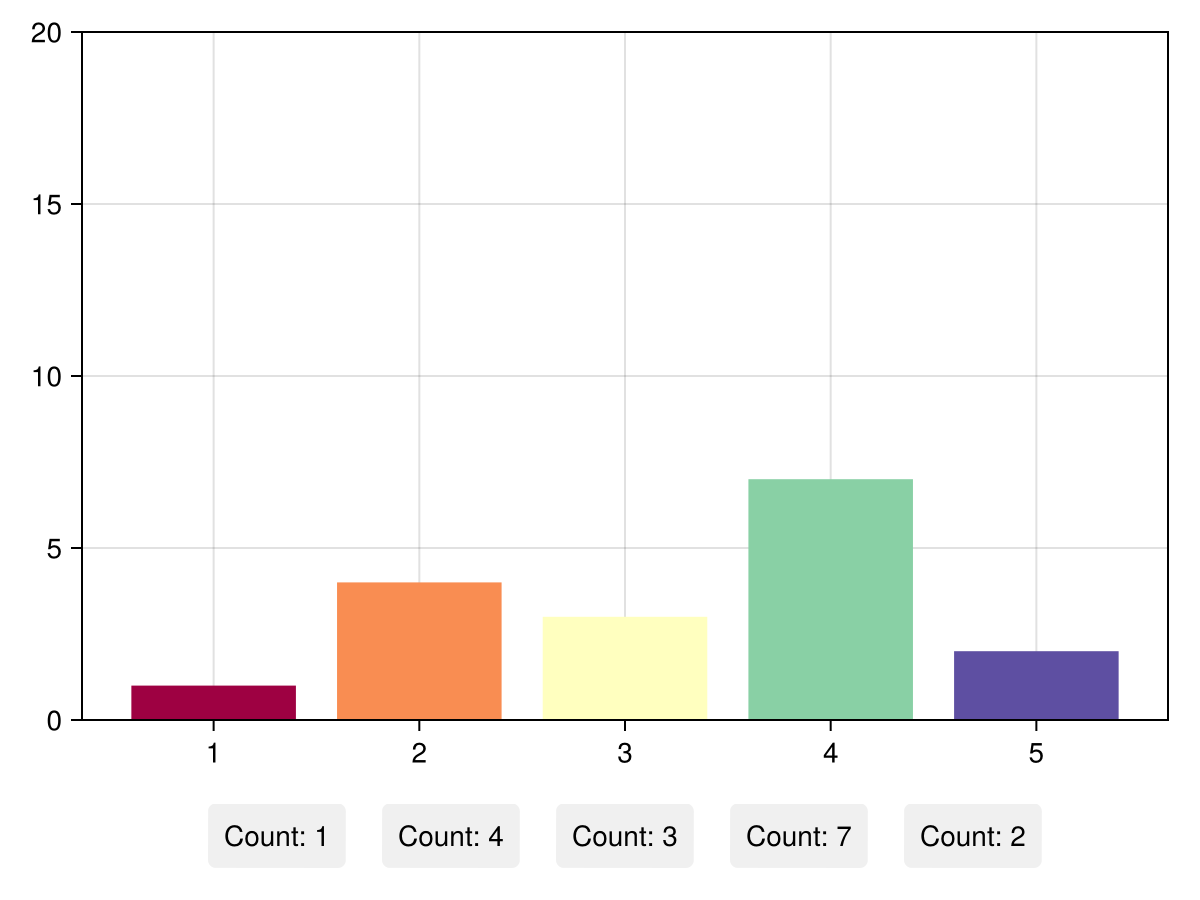

In [15]:
using GLMakie

fig = Figure()

ax = Axis(fig[1, 1])
fig[2, 1] = buttongrid = GridLayout(tellwidth = false)

counts = Observable([1, 4, 3, 7, 2])

buttonlabels = [lift(x -> "Count: $(x[i])", counts) for i in 1:5]

buttons = buttongrid[1, 1:5] = [Button(fig, label = l) for l in buttonlabels]

for i in 1:5
    on(buttons[i].clicks) do n
        counts[][i] += 1
        notify(counts)
    end
end

barplot!(counts, color = cgrad(:Spectral)[LinRange(0, 1, 5)])
ylims!(ax, 0, 20)

fig

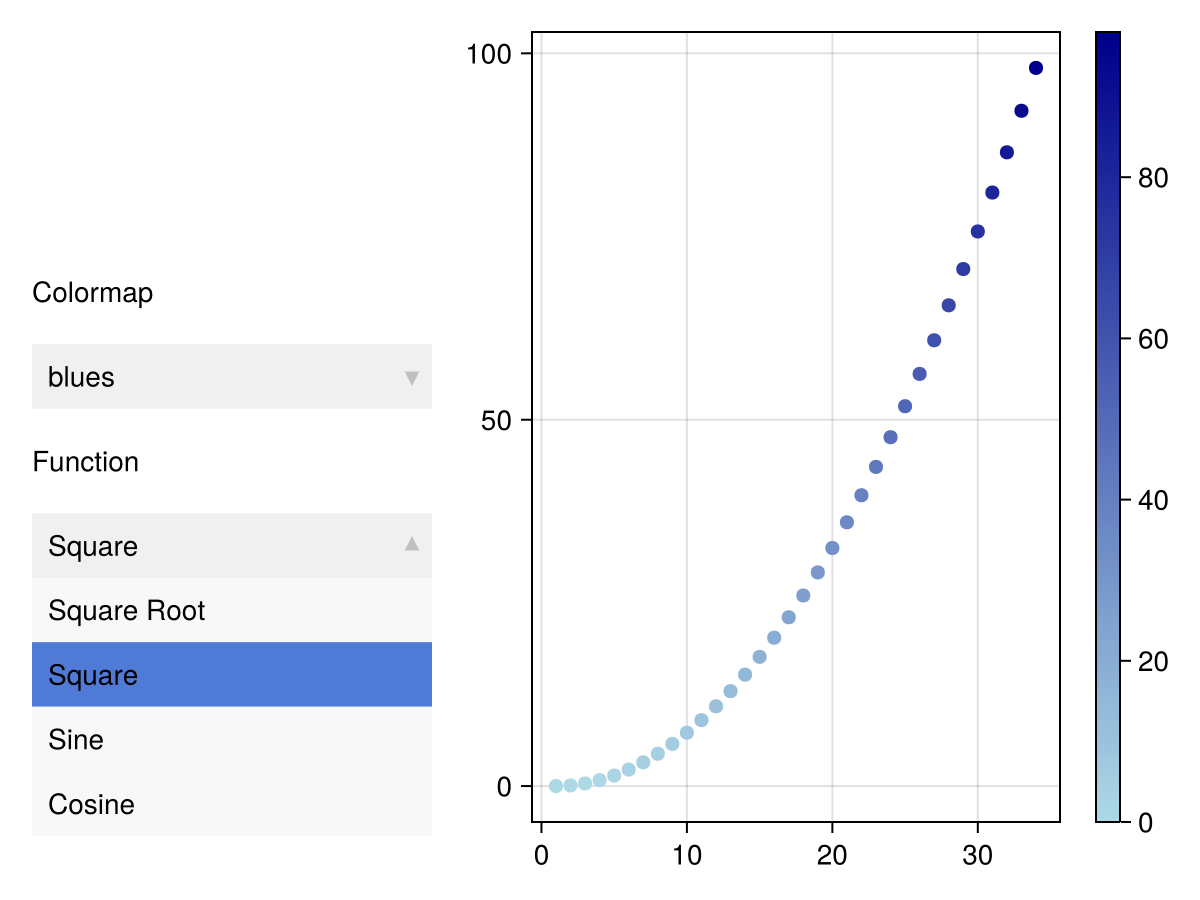

In [16]:
using GLMakie
fig = Figure()

menu = Menu(fig, options = ["viridis", "heat", "blues"], default = "blues")

funcs = [sqrt, x->x^2, sin, cos]

menu2 = Menu(fig,
    options = zip(["Square Root", "Square", "Sine", "Cosine"], funcs),
    default = "Square")

fig[1, 1] = vgrid!(
    Label(fig, "Colormap", width = nothing),
    menu,
    Label(fig, "Function", width = nothing),
    menu2;
    tellheight = false, width = 200)

ax = Axis(fig[1, 2])

func = Observable{Any}(funcs[1])

ys = lift(func) do f
    f.(0:0.3:10)
end
scat = scatter!(ax, ys, markersize = 10px, color = ys)

cb = Colorbar(fig[1, 3], scat)

on(menu.selection) do s
    scat.colormap = s
end
notify(menu.selection)

on(menu2.selection) do s
    func[] = s
    autolimits!(ax)
end
notify(menu2.selection)

menu2.is_open = true

fig

In [2]:
using GLMakie, GraphMakie, Graphs, Graphs.SimpleGraphs, Makie, Observables
import NetworkLayout
GLMakie.activate!()

function modify_element!(x, visible, width, height)
    x.blockscene.visible[] = visible
    x.width[] = width
    x.height[] = height
end
hide_element!(x) = modify_element!(x, false, Fixed(0), Fixed(0))
hide_slider!(x) = hide_element!(x)
hide_label!(x)  = hide_element!(x)
show_slider!(x) = modify_element!(x, true, 300,     Auto(0)) # width matches initialize_sliders!
show_label!(x)  = modify_element!(x, true, Auto(0), Auto(0))

function show_slidergrid!(slidergrid)
    show_slider!( slidergrid)             # show the selected slidergrid
    show_slider!.(slidergrid.sliders)     # show the sliders within the selected grid
    show_label!.( slidergrid.labels)      # show the labels  within the selected grid
    show_label!.( slidergrid.valuelabels) # hides the right-labels of the non-selected grid
end

function hide_slidergrid!(slidergrid)
    hide_slider!( slidergrid)             # hides the non-selected slidergrid
    hide_slider!.(slidergrid.sliders)     # hides the sliders of the non-selected grid
    hide_label!.( slidergrid.labels)      # hides the left-labels  of the non-selected grid
    hide_label!.( slidergrid.valuelabels) # hides the right-labels of the non-selected grid
end

function toggle_slidergrid!(slidervec, i)

    show_slidergrid!(slidervec[i])
    for j in 1:i-1
        hide_slidergrid!(slidervec[j])
    end
    for j in i+1:length(slidervec)
        hide_slidergrid!(slidervec[j])
    end
end

function initialize_sliders!(fig)
    SliderGrid(
        fig[2, 1],
        (label = "n", range = 3:7,     format = "{:d}",   startvalue = 3),
        (label = "p", range = 0:.05:1, format = "{:.2f}", startvalue = .1),
        width = 250,
        halign = :left,
        tellheight = false
    )
    SliderGrid(
        fig[2, 1],
        (label = "n", range = 3:7,      format = "{:d}",   startvalue = 3),
        (label = "k", range = 0:8,      format = "{:d}",   startvalue = 1),
        (label = "β", range = 0:.05:10, format = "{:.2f}", startvalue = .1),
        width = 300,
        halign = :left,
        tellheight = false
    )

    slidervec = contents(fig[2, 1])
    toggle_slidergrid!(slidervec, 1)

    return slidervec

end

function updateNetwork!(ax, method, value)

    @show method, value

    if method == "Erdos–Renyi"
        n, p = value[1:2]
        g = erdos_renyi(n, p)
    elseif method == "Watts-Strogatz"
        n, k, β = value[3:end]
        k = min(n - 1, k)
        g = watts_strogatz(n, k, β)
    end

    println(Graphs.adjacency_matrix(g))
    empty!(ax)
    xlims!(ax, -1.1, 1.1)
    ylims!(ax, -1.1, 1.1)
    graphplot!(ax, g; layout = NetworkLayout.Shell())
    Makie.hidedecorations!(ax)
    Makie.hidespines!(ax)
    ax.aspect = Makie.DataAspect()

end

fig = Figure(fontsize = 30, resolution=(1000, 1000),
    figure_padding = (60, 5, 5, 5) # without padding the label left of the slider fall of the figure area and is hidden
)

menu = Menu(fig[1, 1],
    options = ["Erdos–Renyi", "Watts-Strogatz"],
    default = "Erdos–Renyi"
)

slidervec = initialize_sliders!(fig)

on(menu.i_selected) do i
    println("changing sliders")
    @show i
    toggle_slidergrid!(slidervec, i)
end

ax = Axis(fig[1:2, 2])
sliderobservables = [async_latest(s.value) for sg in slidervec for s in sg.sliders]

map(menu.selection, sliderobservables...) do m, value...

    println("changing plot")
    @show m, value
    updateNetwork!(ax, m, value)

end

fig

ArgumentError: ArgumentError: Package GraphMakie not found in current path.
- Run `import Pkg; Pkg.add("GraphMakie")` to install the GraphMakie package.

In [3]:
using GLMakie

T = 10

pts = range(-1, 1, length=100)
ts = reshape(1:T, 1, 1, :)
topo = cos.(pts) .+ cos.(ts .* pts')

fig = Figure()
ax = Axis(fig[1, 1])

sg = SliderGrid(fig[2,1],
    (label="time", range=1:T))

time = sg.sliders[1].value

str = lift(t -> "[$t ms]", time)
text!(ax, str)

topo_slice = lift((t, data) -> data[:, :, t], time, topo)
contour!(ax, topo_slice)

hidedecorations!(ax)
hidespines!(ax) 
fig

In [4]:
using GLMakie

function run(datadir::String, extension::String)

	fig = Figure()
	sc = display(fig)

	
	xdata = [rand(10)]
	ydata = [rand(10)]
	xs = Observable(xdata[1])
	ys = Observable(ydata[1])
	plotnames = Observable(["nothing"])
	plotname = Observable(plotnames[][1])

	menu = Menu(fig, options = plotnames)
	fig[1, 1] = vgrid!(
		 Label(fig, "Data", width = nothing), menu;
		 tellheight = false, width = 200
		 )
	
	ax = Axis(fig[1, 2], title = plotname)
	line = lines!(ax, xs, ys)

	on(menu.selection) do s
		 i = to_value(menu.i_selected)
		 xs.val = xdata[i]
		 ys[] = ydata[i]
		 autolimits!(ax)
		 ax.title = plotnames[][i]
	end

	while true
		 (file, event) = watch_folder(datadir)

		 if endswith(file, extension)

			  x, y, name = loadfile(datadir, file, extension)

			  if !(name in plotnames[])
					xs.val = x
					ys[] = y
					autolimits!(ax)
					ax.title = name

					push!(xdata, x)
					push!(ydata, y)
					plotnames[] = push!(plotnames[], name)
			  end
		 end
	end

end

run (generic function with 1 method)